In [1]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)
import helper as h
importlib.reload(h)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgbm

import torch
import torch.nn as nn


import torch.distributions as dis

## Test importable Dynamic Acceptance Loop

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 68)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 68)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 68)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 68)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 68)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 68)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 68)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 68)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 68)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 68)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 68)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 68)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

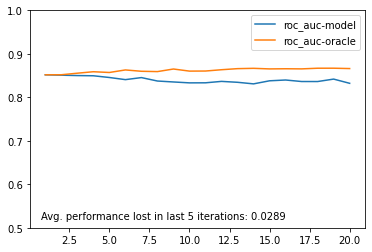

Sampling Bias: 0.0289


In [2]:
n_years = 20

model = lgbm.LGBMClassifier() # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)#rinf.EMsemisupervised)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
#plt.plot(x, results["holdout"]['precision'], label = 'precision')
#plt.plot(x, results["holdout"]['f1'], label = 'f1')
#plt.plot(x, results["holdout"]['accuracy'], label = 'accuracy')
plt.text(0.75, 0.52, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()


print(f'Sampling Bias: {round(bias, 5)}')

In [3]:
print(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years))

0.02889762884264526


## Test importable Autoencoder

In [7]:
import autoencoder as aenc
import importlib
importlib.reload(aenc)

<module 'autoencoder' from 'c:\\Projects\\Information-Systems-Seminar\\reject-infer-autoencoder\\notebooks\\../src\\autoencoder.py'>

Autoencoder(
  (enc): ModuleList(
    (0): Linear(in_features=68, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=20, bias=True)
  )
  (dec): ModuleList(
    (0): Linear(in_features=20, out_features=35, bias=True)
    (1): Linear(in_features=35, out_features=68, bias=True)
  )
)
Epoch 1 of 20, Train Loss: 0.1984 (MMSE: 0.9915 | MMD: 2.1907 | KLD: 0.0001)
Epoch 2 of 20, Train Loss: 0.1880 (MMSE: 0.9368 | MMD: 3.1747 | KLD: 0.0007)
Epoch 3 of 20, Train Loss: 0.1755 (MMSE: 0.8745 | MMD: 4.3598 | KLD: 0.0008)
Epoch 4 of 20, Train Loss: 0.1621 (MMSE: 0.8064 | MMD: 5.2227 | KLD: 0.0010)
Epoch 5 of 20, Train Loss: 0.1497 (MMSE: 0.7462 | MMD: 5.7842 | KLD: 0.0006)
Epoch 6 of 20, Train Loss: 0.1406 (MMSE: 0.7009 | MMD: 5.8683 | KLD: 0.0006)
Epoch 7 of 20, Train Loss: 0.1331 (MMSE: 0.6639 | MMD: 5.3891 | KLD: 0.0004)
Epoch 8 of 20, Train Loss: 0.1270 (MMSE: 0.6333 | MMD: 4.7340 | KLD: 0.0004)
Epoch 9 of 20, Train Loss: 0.1218 (MMSE: 0.6077 | MMD: 4.3043 | KLD: 0.0003)
Ep

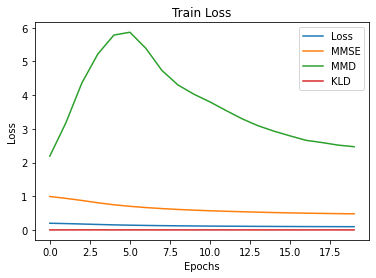

In [8]:
BATCH_SIZE = 2000
EPOCHS = 20
LR = 1e-3

dataset = aenc.CreditscoringDataset("gmsc.csv")      # load and prepare Dataset to Tensor
data_loader = aenc.DataLoader(                       # create Dataloader for batching
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

shape = [dataset.x.shape[1], 35, 20, 35, dataset.x.shape[1]]  # define shape of Autoencoder
net = aenc.Autoencoder(shape)
print(net)
net.to("cpu")

train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net, data_loader, EPOCHS, LR)               

plt.figure()
plt.plot(train_loss, label='Loss')
plt.plot(train_loss_mmse, label='MMSE')
plt.plot(train_loss_mmd, label='MMD')
plt.plot(train_loss_kld, label='KLD')
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Itteration: 0) Accepted: 1822 | Denied: 4253 - New train set size: (16822, 20)
Itteration: 1) Accepted: 1822 | Denied: 4253 - New train set size: (18644, 20)
Itteration: 2) Accepted: 1822 | Denied: 4253 - New train set size: (20466, 20)
Itteration: 3) Accepted: 1822 | Denied: 4253 - New train set size: (22288, 20)
Itteration: 4) Accepted: 1822 | Denied: 4253 - New train set size: (24110, 20)
Itteration: 5) Accepted: 1822 | Denied: 4253 - New train set size: (25932, 20)
Itteration: 6) Accepted: 1822 | Denied: 4253 - New train set size: (27754, 20)
Itteration: 7) Accepted: 1822 | Denied: 4253 - New train set size: (29576, 20)
Itteration: 8) Accepted: 1822 | Denied: 4253 - New train set size: (31398, 20)
Itteration: 9) Accepted: 1822 | Denied: 4253 - New train set size: (33220, 20)
Itteration: 10) Accepted: 1822 | Denied: 4253 - New train set size: (35042, 20)
Itteration: 11) Accepted: 1822 | Denied: 4253 - New train set size: (36864, 20)
Itteration: 12) Accepted: 1822 | Denied: 4253 - Ne

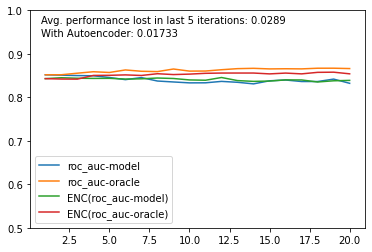

In [9]:
n_years = 20

sim = dal.Simulate_acceptance_loop("gmsc.csv", model, 0.1, 0.1, n_years, enc_features=True, encoder=net)#, rej_inf=rinf.EMsemisupervised)
results_generator = sim.run()

metrics2 = None
for iteration in results_generator:
    print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics2 = iteration[3]

last_n_years = 5
bias2 = h.measure_bias(metrics2["oracle"]["holdout"]['roc_auc'], metrics2["model"]["holdout"]['roc_auc'], last_n_years)
    
x = range(1, n_years + 1)
plt.plot(x, metrics["model"]["holdout"]['roc_auc'], label = 'roc_auc-model')
plt.plot(x, metrics["oracle"]["holdout"]['roc_auc'], label = 'roc_auc-oracle')
plt.plot(x, metrics2["model"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-model)')
plt.plot(x, metrics2["oracle"]["holdout"]['roc_auc'], label = 'ENC(roc_auc-oracle)')
plt.text(0.75, 0.97, f'Avg. performance lost in last {last_n_years} iterations: {round(bias, 5)}')
plt.text(0.75, 0.94, f'With Autoencoder: {round(bias2, 5)}')
plt.legend()
plt.ylim([0.5, 1.0])
plt.show()